# This notebook simulates the effect of compression of mortality

# Imports

In [2]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
from scipy.signal import savgol_filter
from scipy import stats

# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
import src.survival_analysis as sa
import src.hetero_plotting as hp
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc

# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sweden_cohort_f = HMD(country='swe', gender = 'female', data_type = 'cohort')
sweden_cohort_m = HMD(country='swe' , gender = 'male', data_type = 'cohort')
sweden_cohort_b = HMD(country='swe' , gender = 'both', data_type = 'cohort')

sweden_period_m = HMD(country='swe' , gender = 'male', data_type = 'period')
sweden_period_f = HMD(country='swe' , gender = 'female', data_type = 'period')

denmark_cohort_m = HMD(country='dan' , gender = 'male', data_type = 'cohort')
denmark_cohort_f = HMD(country='dan' , gender = 'female', data_type = 'cohort')
denmark_cohort_b = HMD(country='dan' , gender = 'both', data_type = 'cohort')

denmark_period_b = HMD(country='dan' , gender = 'both', data_type = 'period')

years = np.arange(1870, 1901, 5)









# Denmark

### original simulation, constant h_ext for all

In [4]:
# Get SR parameters from model_param_calibrations
sr_params = pc.sr_calibrations['denmark']
sr_dict = pc.country_dicts['denmark']
n = int(1e5)

# Create MZ and DZ parameter distributions
dict_original = utils.create_param_distribution_dict(
    params_dict=sr_dict,
    params='Xc',
    std=sr_params['Xc_std'], 
    n=n,
    family='MZ'
)

# Create simulations for MZ and DZ twins
sim_denmark = utils.create_sr_simulation(
    params_dict=dict_original,
    parallel=True,
    tmax=140,
    n=n,
    h_ext=sr_params['m_ex'],
    break_early=True
)

# Create simulations for MZ and DZ twins
sim_denmark_no_ext = utils.create_sr_simulation(
    params_dict=dict_original,
    parallel=True,
    tmax=140,
    n=n,
    h_ext=None,
    break_early=True
)


plotter_denmark = SR_plotting(sim_denmark)
plotter_denmark_no_ext = SR_plotting(sim_denmark_no_ext)


### fits for historical cohorts

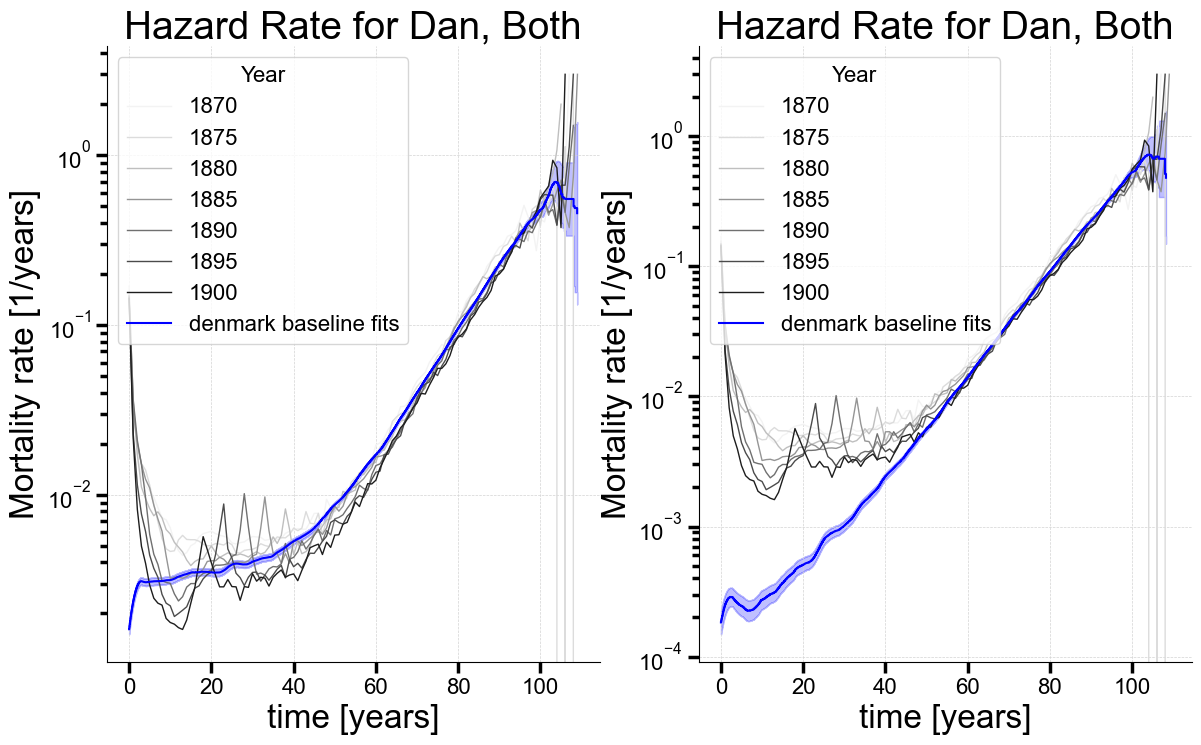

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))

denmark_cohort_b.plot_hazard(years = [1870, 1875, 1880, 1885, 1890, 1895, 1900], ax = ax1, linewidth = 1, cmap = 'Greys')
plotter_denmark.plot_hazard(ax=ax1, label='denmark baseline fits', color = 'blue')

denmark_cohort_b.plot_hazard(years = [1870, 1875, 1880, 1885, 1890, 1895, 1900], ax = ax2, linewidth = 1, cmap = 'Greys')
plotter_denmark_no_ext.plot_hazard(ax=ax2, label='denmark baseline fits', color = 'blue')






### while for modern cohorts clearly the old fits are bad:

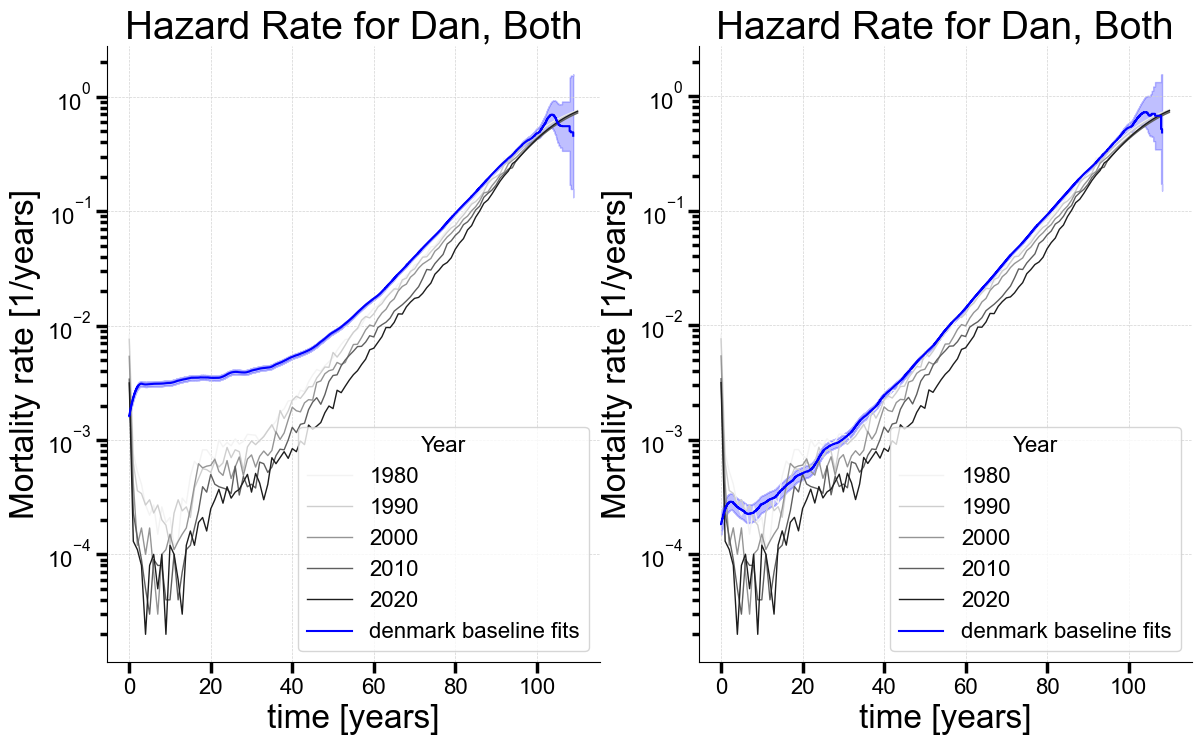

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))

denmark_period_b.plot_hazard(years = [1980, 1990, 2000, 2010, 2020], ax = ax1, linewidth = 1, cmap = 'Greys')
plotter_denmark.plot_hazard(ax=ax1, label='denmark baseline fits', color = 'blue')

denmark_period_b.plot_hazard(years = [1980, 1990, 2000, 2010, 2020], ax = ax2, linewidth = 1, cmap = 'Greys')
plotter_denmark_no_ext.plot_hazard(ax=ax2, label='denmark baseline fits', color = 'blue')






### fits for modern denmark survival

In [ ]:
# Get SR parameters from model_param_calibrations
sr_params = pc.sr_calibrations['denmark'].copy()
sr_dict = pc.country_dicts['denmark'].copy()
n = int(2e4)
# increase of 15% for modern cohorts
sr_dict['Xc'] = 1.15*sr_dict['Xc']

# Create MZ and DZ parameter distributions
dict_denmark_modern = utils.create_param_distribution_dict(
    params_dict=sr_dict,
    params='Xc',
    std=sr_params['Xc_std'], 
    n=n,
    family='MZ'
)


# Create simulations for MZ and DZ twins
sim_denmark_modern = utils.create_sr_simulation(
    params_dict=dict_denmark_modern,
    parallel=False,
    tmax=140,
    n=n,
    h_ext=None,
    break_early=True
)

plotter_denmark_modern = SR_plotting(sim_denmark_modern)

print('correlation with modern parameters:')
print(round(ca.calc_pearson_corr_twin_deaths(sim_denmark_modern, filter_age=15), 2))




correlation with modern parameters:
0.52


correlation with modern parameters:
0.52


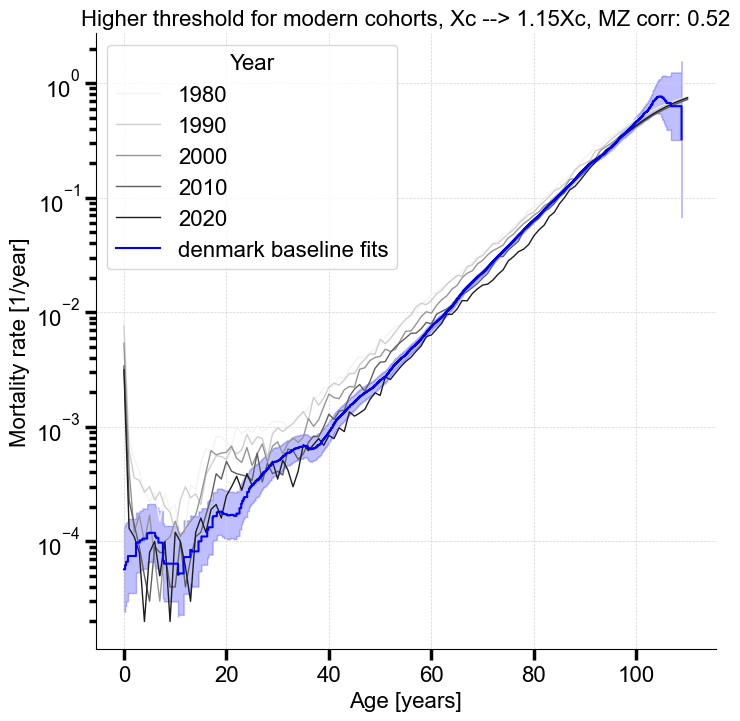

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

denmark_period_b.plot_hazard(years = [1980, 1990, 2000, 2010, 2020], ax = ax, linewidth = 1, cmap = 'Greys')
plotter_denmark_modern.plot_hazard(ax=ax, label='denmark baseline fits', color = 'blue')

print('correlation with modern parameters:')
print(round(ca.calc_pearson_corr_twin_deaths(sim_denmark_modern, filter_age=15), 2))

ax.set_title(f'Higher threshold for modern cohorts, Xc --> 1.15Xc, MZ corr: {round(ca.calc_pearson_corr_twin_deaths(sim_denmark_modern, filter_age=15), 2)}', fontsize = 16)
ax.set_xlabel('Age [years]', fontname='Arial', fontsize = 16)
ax.set_ylabel('Mortality rate [1/year]', fontname='Arial', fontsize = 16)
ax.set_yscale('log')




# checking factor effect

In [9]:
# Get SR parameters from model_param_calibrations

n = int(1e5)

# Create loop for different factors
factors = np.arange(0.7, 1.41, 0.05)
correlations = []

for fac in factors:
    # Create MZ and DZ parameter distributions
    sr_params = pc.sr_calibrations['denmark'].copy()
    sr_dict = pc.country_dicts['denmark'].copy()
    
    sr_dict['Xc'] = fac*sr_dict['Xc']
    print(sr_dict['Xc'])
    dict_denmark_modern = utils.create_param_distribution_dict(
        params_dict=sr_dict,
        params='Xc',
        std=sr_params['Xc_std'], 
        n=n,
        family='MZ'
    )

    # Create simulations for MZ and DZ twins
    sim_denmark_modern = utils.create_sr_simulation(
        params_dict=dict_denmark_modern,
        parallel=True,
        tmax=140,
        n=n,
        h_ext=None,
        break_early=True
    )

    # Calculate correlation and save
    corr = ca.calc_pearson_corr_twin_deaths(sim_denmark_modern, filter_age=15)
    correlations.append(corr)
    
    print(f'Factor {fac:.2f}: correlation = {round(corr, 3)}')




11.899999999999999
Factor 0.70: correlation = 0.526
12.75
Factor 0.75: correlation = 0.534
13.600000000000001
Factor 0.80: correlation = 0.532
14.450000000000001
Factor 0.85: correlation = 0.541
15.300000000000002
Factor 0.90: correlation = 0.542
16.150000000000002
Factor 0.95: correlation = 0.539
17.000000000000004
Factor 1.00: correlation = 0.54
17.850000000000005
Factor 1.05: correlation = 0.531
18.700000000000006
Factor 1.10: correlation = 0.527
19.550000000000004
Factor 1.15: correlation = 0.526
20.400000000000006
Factor 1.20: correlation = 0.514
21.250000000000007
Factor 1.25: correlation = 0.512
22.10000000000001
Factor 1.30: correlation = 0.496
22.95000000000001
Factor 1.35: correlation = 0.498
23.80000000000001
Factor 1.40: correlation = 0.488


## the figure

In [11]:
t_vec, avg_hazard, lower_hazard, upper_hazard = denmark_cohort_b.log_average_hazard_curve(years=np.arange(1870, 1901, 1))


correlation with modern parameters:
0.49


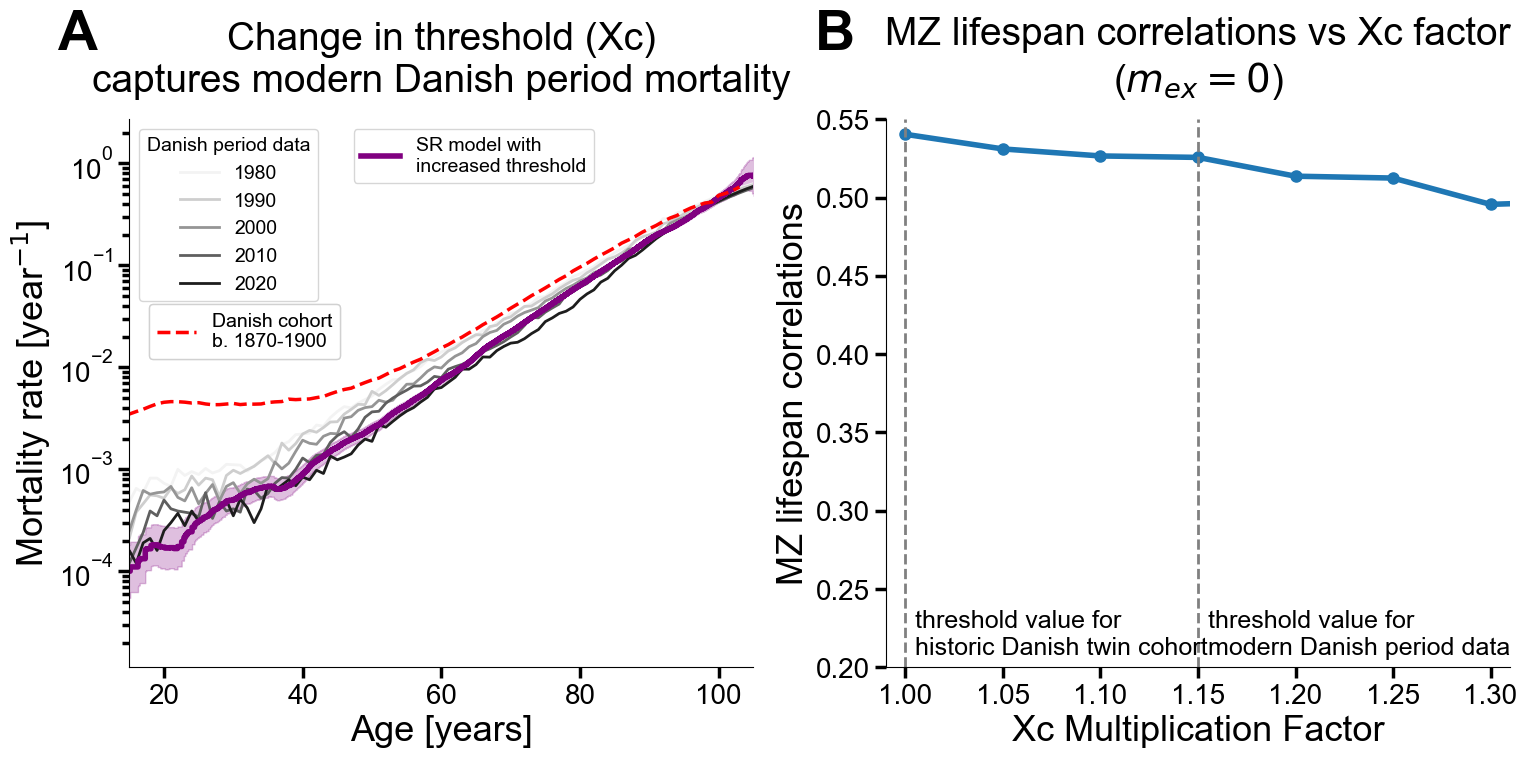

In [12]:


# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0.4)  # Add more whitespace between columns

# ============================================================================
# PANEL A: HAZARD PLOT
# ============================================================================
ax1 = axes[0]

# Plot Danish period data (1980-2020)
lines1 = denmark_period_b.plot_hazard(
    years=[1980, 1990, 2000, 2010, 2020], 
    ax=ax1, 
    linewidth=2, 
    cmap='Greys'
)
handles1, labels1 = ax1.get_legend_handles_labels()

# Plot SR model with increased threshold
line2 = plotter_denmark_modern.plot_hazard(
    ax=ax1, 
    label='SR model with\nincreased threshold', 
    color='purple', 
    linewidth=4
)

# Handle SR model legend entry
if isinstance(line2, list):
    handles2 = [l for l in line2 if l is not None]
else:
    handles2 = [line2] if line2 is not None else []

labels2 = []
for h in handles2:
    label = h.get_label() if hasattr(h, "get_label") else None
    if not label or label == "_nolegend_":
        label = "SR model with\nincreased threshold"
    labels2.append(label)

# Create proxy artist if no handles available
if not handles2:
    from matplotlib.lines import Line2D
    handles2 = [Line2D([0], [0], color='purple', linewidth=4)]
    labels2 = ["SR model with\nincreased threshold"]

# Plot Danish cohort data (born 1870-1900)
cohort_line, = ax1.plot(
    t_vec, avg_hazard, 
    linestyle='--', 
    color='red', 
    linewidth=2.5, 
    label='Danish cohort b. 1870-1900'
)
handles3 = [cohort_line]
labels3 = ['Danish cohort\nb. 1870-1900']

# Calculate and print correlation
corr_modern = round(ca.calc_pearson_corr_twin_deaths(sim_denmark_modern, filter_age=15), 2)
print('correlation with modern parameters:')
print(corr_modern)

# ============================================================================
# PANEL B: CORRELATION VS XC FACTOR
# ============================================================================
ax2 = axes[1]

# Plot correlation data
ax2.plot(factors[6:], correlations[6:], 'o-', 
         linewidth=4, markersize=8, 
         label='MZ lifespan correlations', color='C0')

# Add vertical reference lines
ax2.vlines(x=1, ymin=0.2, ymax=0.55, color='grey', linestyle='--', linewidth=2)
ax2.text(1.005, 0.205, 'threshold value for\nhistoric Danish twin cohort', 
         fontname='Arial', fontsize=18, va='bottom')

ax2.vlines(x=1.15, ymin=0.2, ymax=0.55, color='grey', linestyle='--', linewidth=2)
ax2.text(1.155, 0.205, 'threshold value for\nmodern Danish period data', 
         fontname='Arial', fontsize=18, va='bottom')

# ============================================================================
# FORMATTING FOR BOTH PANELS
# ============================================================================
# Define font sizes for consistent formatting
title_size = 28
label_size = 26
legend_size = 14
legend_title_size = 14
tick_size = 20

# Panel A formatting
ax1.set_title('Change in threshold (Xc)\ncaptures modern Danish period mortality', 
              fontname='Arial', fontsize=title_size, pad=20)
ax1.set_xlabel('Age [years]', fontname='Arial', fontsize=label_size)
ax1.set_ylabel('Mortality rate [year$^{-1}$]', fontname='Arial', fontsize=label_size)
ax1.set_yscale('log')
ax1.set_xlim(15, 105)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

# Remove existing legends from Panel A
if hasattr(ax1, 'legend_') and ax1.legend_:
    ax1.legend_.remove()

# Add multiple legends to Panel A
legend1 = ax1.legend(
    handles=handles1, labels=labels1, 
    title="Danish period data", 
    fontsize=legend_size, title_fontsize=legend_title_size, 
    loc='upper left', bbox_to_anchor=(0, 1)
)
ax1.add_artist(legend1)

legend2 = ax1.legend(
    handles=handles2, labels=labels2, 
    title=None, fontsize=legend_size, 
    loc='upper right', bbox_to_anchor=(0.76, 1)
)
ax1.add_artist(legend2)

legend3 = ax1.legend(
    handles=handles3, labels=labels3,
    title=None, fontsize=legend_size,
    loc='upper right', bbox_to_anchor=(0.353, 0.68)
)
ax1.add_artist(legend3)

# Panel B formatting
ax2.set_title('MZ lifespan correlations vs Xc factor\n($m_{ex} = 0$)', 
              fontname='Arial', fontsize=title_size, pad=20)
ax2.set_xlabel('Xc Multiplication Factor', fontname='Arial', fontsize=label_size)
ax2.set_ylabel('MZ lifespan correlations', fontname='Arial', fontsize=label_size)
ax2.set_ylim(0.2, 0.55)
ax2.set_xlim(0.99, 1.31)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

# Add panel labels
ax1.text(-0.05, 1.2, 'A', transform=ax1.transAxes, 
         fontsize=40, fontweight='bold', va='top', ha='right')
ax2.text(-0.05, 1.2, 'B', transform=ax2.transAxes, 
         fontsize=40, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()
